# 10-5-3 network decay tests

In [974]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
dtype = torch.float
device = torch.device("cpu")
device = torch.device("cuda:0") # Uncomment this to run on GPU
import NeuralNetwork as NN
import FFNetwork as FF
import Layer
import importlib
import time
from IPython.display import display
from ipywidgets import FloatProgress
from copy import deepcopy
importlib.reload(NN)
importlib.reload(Layer);

In [399]:
def ClassPlot(x, labels=[], idx=(1,2), equal=True):
    # FeedForward
    #yc = Network.OneHot(y)
    if len(labels)>0:
        colour_options = ['y', 'r', 'g', 'b', 'k']
        cidx = np.argmax(labels, axis=1)
        colours = [colour_options[k] for k in cidx]
        plt.scatter(x[:,idx[0]], x[:,idx[1]], color=colours, marker='.')
    else:
        plt.scatter(x[:,idx[0]], x[:,idx[1]], marker='.')
    if equal:
        plt.axis('equal');

## Create a simple dataset

In [400]:
# This creates a dataset

n_classes = 3
hidden_dim = 5
sensory_dim = 10

B = np.eye(n_classes)
X = 3.*(np.random.rand(sensory_dim, n_classes) - 0.5)
A = X.T
print('Bottom vectors')
print(B)
print('Top vectors')
print(A)
#print('System matrix:\n'+str(M))

Bottom vectors
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
Top vectors
[[ 2.81545125e-01  4.66284464e-01  1.17578046e+00  2.80777722e-01
  -9.98590398e-01 -1.34068038e+00 -1.22477599e+00 -4.35146799e-01
  -1.00668904e+00  1.22099385e+00]
 [ 1.27140329e+00  7.51001898e-01  6.46658821e-02 -3.09697092e-02
  -1.53034832e-01 -4.57793366e-01  9.34368604e-01  7.71819893e-01
   1.44365010e+00 -9.80089022e-01]
 [ 1.13260480e+00 -1.41664573e+00 -2.49025374e-01 -7.68324958e-01
   5.30640389e-01 -2.12854585e-01  1.14924141e-03 -1.08392019e+00
  -3.72873557e-01  7.83174609e-01]]


In [401]:
# Use A and B to make a dataset
n_classes, top_dim = np.shape(A)
bottom_dim = n_classes

training_samples = 500
noise = 0.2
training_input = []
training_output = []
for n in range(training_samples):
    r = np.random.randint(n_classes)
    training_input.append(B[r])
    training_output.append(A[r]+noise*np.random.normal(size=np.shape(A[r])))

training_input = torch.tensor(training_input).float().to(device)
training_output = torch.tensor(training_output).float().to(device)
train = [training_input, training_output]

In [402]:
# Use A and B to make a dataset
def MakeDataset(A, B, n=300, noise=0.2):
    n_classes, top_dim = np.shape(A)
    bottom_dim = n_classes

    training_samples = n
    #noise = 0.2
    training_input = []
    training_output = []
    for n in range(training_samples):
        r = np.random.randint(n_classes)
        training_input.append(B[r])
        training_output.append(A[r]+noise*np.random.normal(size=np.shape(A[r])))

    training_input = torch.tensor(training_input).float().to(device)
    training_output = torch.tensor(training_output).float().to(device)
    train = [training_input, training_output]
    return train

In [403]:
train = MakeDataset(A, B)

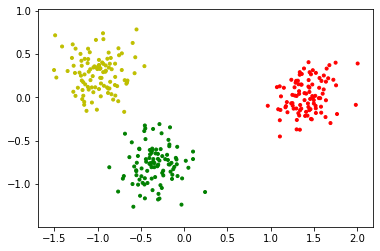

In [406]:
ClassPlot(train[1].cpu(), labels=train[0].cpu(), idx=(8,3))

# Weight Decay Benefits

In [ ]:
num_networks=10
for k in range(num_networks):
    net = NN.NeuralNetwork()
    net.AddLayer(Layer.InputPELayer(n=n_classes))
    net.AddLayer(Layer.PELayer(n=hidden_dim))
    net.AddLayer(Layer.TopPELayer(n=sensory_dim))

    sym = False
    af = 'identity'
    net.Connect(0, 1, act=af, symmetric=sym)
    net.Connect(1, 2, act=af, symmetric=sym)

    net.SetTau(0.02)
    net.learning_tau = 0.1
    net.learn_biases = False
    net.learning_blackout=2.0

    # Make two copies
    net0 = deepcopy(net)
    net1 = deepcopy(net)

    net0.SetWeightDecay(0.0)
    net0.SetvDecay(0.0)
    net0.Learn(train[0], train[1], T=5., dt=0.001, epochs=10, batch_size=20)
    
    net1.SetWeightDecay(0.05)
    net1.SetvDecay(0.0)
    net1.Learn(train[0], train[1], T=5., dt=0.001, epochs=10, batch_size=20)
    
    net_nodecay.append(net0)
    net_decay.append(net1)

identity
identity


FloatProgress(value=0.0, max=3000.0)

FloatProgress(value=0.0, max=3000.0)

identity
identity


FloatProgress(value=0.0, max=3000.0)

In [1035]:
generated_nodecay_net = []
generated_decay_net = []

for i in range (0, len(net_nodecay)):
    net0 = net_nodecay[i]
    net1 = net_decay[i]
    
    net0.SetTau(0.2)
    net1.SetTau(0.2)
    
    net0.Reset(random=0.)
    net0.SetvDecay(0.01)
    net1.Reset(random=0.)
    net1.SetvDecay(0.01)
    
    y2 = net0.Predict(20., torch.tensor(classes).float().to(device), dt=0.001, random=0.)
    y3 = net1.Predict(20., torch.tensor(classes).float().to(device), dt=0.001, random=0.)

    generated_nodecay_net.append(deepcopy(y2))
    generated_decay_net.append(deepcopy(y3))

In [1039]:
#Calculate average, minimum, and maximum cosine similarity for decay networks
dist_sum = 0
minimum_dist =  180000 #or INT_MAX
max_dist = -179000 #or INT_MIN

for i in range(0, num_networks):
    z2 = generated_decay_net[i]    
    
    dist=0
    for j in range(0, num_classes):
        dist = torch.norm(z2[j] - torch.tensor(A[j]).float().to(device))
        if dist < minimum_dist:
            minimum_dist = dist
        if dist > max_dist:
            max_dist = dist
        dist_sum += dist
    
        
print(dist_sum / (num_networks*3))
print(minimum_dist)
print(max_dist)

tensor(0.3700, device='cuda:0')
tensor(0.2002, device='cuda:0')
tensor(0.6037, device='cuda:0')


In [1040]:
#Calculate average, minimum, and maximum cosine similarity for decay networks
dist_sum = 0
minimum_dist =  180000
max_dist = -179000

for i in range(0, num_networks):
    z2 = generated_nodecay_net[i]    
    
    dist=0
    for j in range(0, num_classes):
        dist = torch.norm(z2[j] - torch.tensor(A[j]).float().to(device))
        if dist < minimum_dist:
            minimum_dist = dist
        if dist > max_dist:
            max_dist = dist
        dist_sum += dist
    
print(dist_sum / (num_networks*3))
print(minimum_dist)
print(max_dist)

tensor(11818.3203, device='cuda:0')
tensor(4.5623, device='cuda:0')
tensor(148102.7969, device='cuda:0')


In [995]:
#Calculate average, minimum, and maximum cosine similarity for decay networks
norm_corr_sum = 0
minimum_corr =  180
max_corr = -179

for i in range(0, num_networks):
    z2 = generated_decay_net[i]    
    corr = 0
    
    for j in range (0, num_classes): 
        corr += np.dot(z2[j].cpu(), A[j]) / (np.linalg.norm(z2[j].cpu())*np.linalg.norm(A[j]))
        
    norm_corr_sum += corr
    corr /= 3
    
    if corr < minimum_corr:
            minimum_corr = corr
    if corr > max_corr:
            max_corr = corr
        
print(norm_corr_sum / (num_networks*3))
print(minimum_corr)
print(max_corr)

0.9915507550432083
0.9884563598932276
0.9951369281126935


In [996]:
#Calculate average, minimum, and maximum cosine similarity for decay networks

norm_corr_sum = 0
minimum_corr =  180
max_corr = -179

for i in range(0, num_networks):
    z2 = generated_nodecay_net[i]    
    corr = 0
    
    for j in range (0, num_classes):
        corr += np.dot(z2[j].cpu(), A[j]) / (np.linalg.norm(z2[j].cpu())*np.linalg.norm(A[j]))
        
    norm_corr_sum += corr
    corr /= 3
    
    if corr < minimum_corr:
        minimum_corr = corr
    if corr > max_corr:
        max_corr = corr

        
print(norm_corr_sum / (num_networks*3))
print(minimum_corr)
print(max_corr)

-0.044870239308864975
-0.32735394111441424
0.2425182259432294


In [699]:
zz2 = generated_decay_net[0]
zz3 = generated_nodecay_net[0]

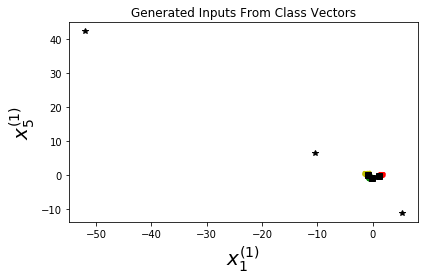

In [700]:
lgnd = ['Weight Decay Training', 'No Weight Decay Training'] #['NoWD NoAD', 'YesWD NoAD', 'YesWD YesAD']

idx=(8,3)
ClassPlot(train[1].cpu(), labels=train[0].cpu(), idx=idx, equal=False)
plt.plot(np.array(zz2[:,idx[0]].cpu()), np.array(zz2[:,idx[1]].cpu()), 'ks');
plt.plot(np.array(zz3[:,idx[0]].cpu()), np.array(zz3[:,idx[1]].cpu()), 'k*');
plt.xlabel('$x_1^{(1)}$', fontsize=20)
plt.ylabel('$x_5^{(1)}$', fontsize=20)
#plt.legend(lgnd)
#plt.ylim((-1.5,1.0))
#plt.xlim((-1.5, 2.0))
plt.title('Generated Inputs From Class Vectors')
plt.tight_layout()
#plt.savefig("no_activity_decay_during_testing.pdf", format='pdf')

a = plt.axis()

In [980]:
print(classes)

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
